# Import all libraries we are going to use

In [1]:
import os
import sys
import time
import shutil
import pathlib
import itertools
from functools import partial
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
# import seaborn as sns
# sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error



# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

#plot style
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams['text.color'] = 'black' 

print ('modules loaded')

modules loaded


# Create function for later

In [ ]:
def getDataSet(categories: list, folder: str):
    images = []
    labels = []
    for category in categories:
        folder_path = os.path.join(folder, category)
        label = categories.index(category)  # Assign a numerical label to each category
        for filename in os.listdir(folder_path):
            if filename.endswith(".jpg"):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224))  # Resize to a common size
                    img = img / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img)
                    labels.append(label)
                else:
                    print(f"Failed to load image: {img_path}")
    return np.array(images), np.array(labels)


def isNumpyData( t: np.ndarray, expected_ndim: int,):
    assert isinstance(expected_ndim, int), f"input parameter 'expected_ndim' is not an integer but a '{type(expected_ndim)}'"
    assert expected_ndim>=0, f"expected input parameter 'expected_ndim' to be >=0, got {expected_ndim}"
    if not isinstance(t, np.ndarray):
        print("excepted numpy.ndarray got type '{type(t)}'", file=sys.stderr)
        return False
    if not t.ndim == expected_ndim:
        print("Input Dimensions={type.ndim} don't match expected dimensions={expected_ndim}", file=sys.stderr)
        return False
    return True

def addCategori(y):
    if y.ndim == 1:
        y = to_categorical(y, num_classes=4)
        return y

def get_index_and_lowest_value(value):
    index = np.argmin(value)
    value_lowest = value[index]
    return index, value_lowest

def get_index_and_highst_value(value):
    index = np.argmax(value)
    value_lowest = value[index]
    return index, value_lowest

def saveModel(name, model):
    model.save_weights('{name}.h5')
    model_json = model.to_json()
    with open('{name}_model_architecture.json', 'w') as json_file:
        json_file.write(model_json)

def getProcessedImage(image_path):
    image = Image.open(image_path)

    img = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

def getModel(name):
    from tf.keras.models import load_model, model_from_json

    with open(f'{name}_model_architecture.json', 'r') as json_file:
        loaded_model_json = json_file.read()

    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(f'{name}.h5')

    cloned_model = tf.keras.models.clone_model(loaded_model)
    cloned_model.set_weights(loaded_model.get_weights())
   
    cloned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cloned_model.summary()
    return cloned_model

# Prepare the data

In [3]:
name = "WeatherModel";

data_folder = "weather_dataset"
categories = ["Shine", "Cloudy", "Rain", "Sunrise"]

#X is images and y is labels
X, y = getDataSet(categories, data_folder)

# Check the data
isNumpyData(X, 4)
isNumpyData(y, 1)

# Add category to label
y_bins_to_plot = y
y = addCategori(y)

# Check category added to label
isNumpyData(y, 2)

Failed to load image: weather_dataset\Shine\shine131.jpg
Failed to load image: weather_dataset\Rain\rain141.jpg


True

## Spilt data into train, validation and test sets

Spilt the set into 80% training 12% validation and 8 % test sets

In [4]:
X_train, X_dummy, y_train, y_dummy = train_test_split(X, y,  train_size= 0.8, shuffle= True, random_state= 123)
X_valid, X_test, y_valid, y_test = train_test_split(X_dummy, y_dummy,  train_size= 0.6, shuffle= True, random_state= 123)

Create images generator

In [5]:
batch_size = 16

train_generator = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_generator = ImageDataGenerator()

train_gen = train_generator.flow(X_train, y_train, shuffle= False, batch_size= batch_size)

valid_gen = test_generator.flow(X_valid, y_valid, shuffle= False, batch_size= batch_size)

test_gen = test_generator.flow(X_test, y_test, shuffle= False, batch_size= batch_size)

## Check the data

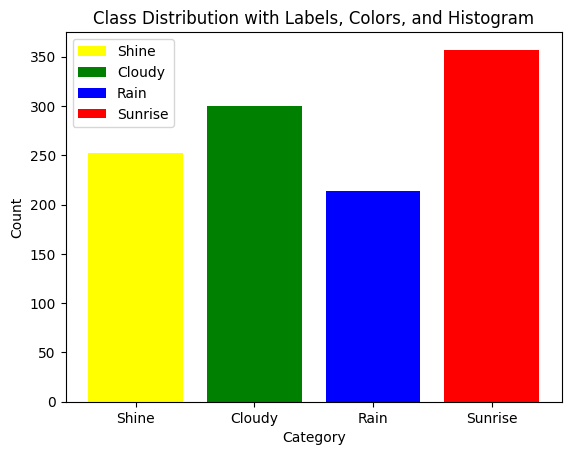

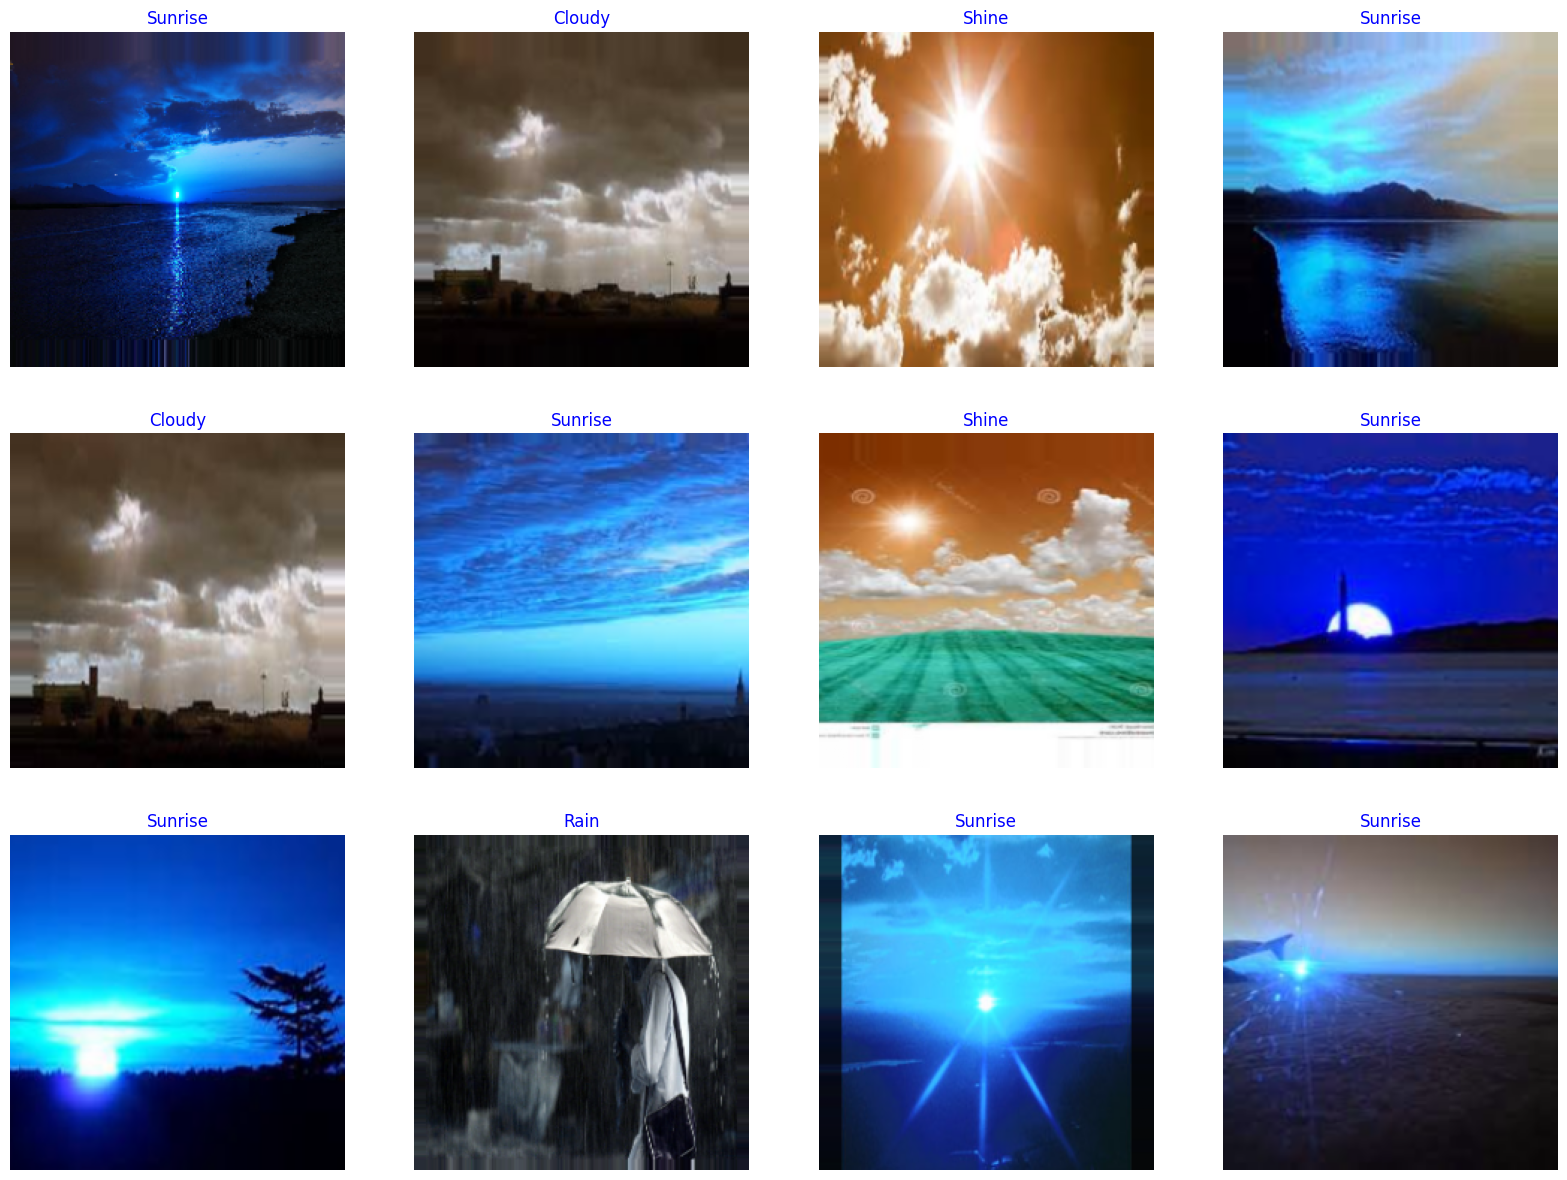

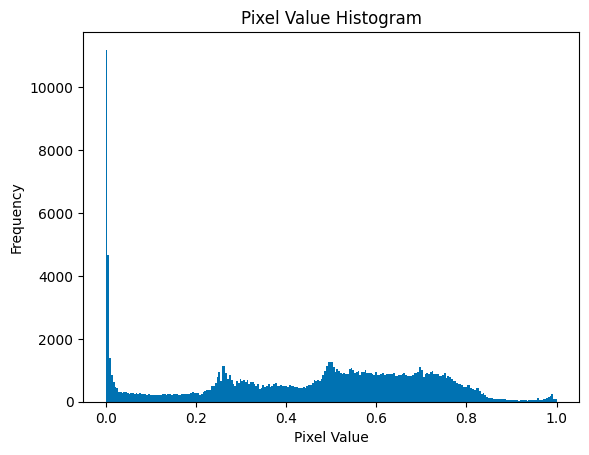

In [6]:
# Plot category distribution
colors = ['yellow', 'green', 'blue', 'red']
fig, ax = plt.subplots()

values, _ = np.histogram(y_bins_to_plot, bins=len(categories))

for i, category in enumerate(categories):
    ax.bar(category, values[i], color=colors[i], label=f'{category}')

ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_title('Class Distribution with Labels, Colors, and Histogram')
ax.legend()
plt.show()

# get a batch size samples from the generator
images, labels = next(train_gen)  

# Plot images
plt.figure(figsize=(20, 20))
for i in range(12):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = categories[index]   # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

# Pixel Value plot
plt.hist(X[0].ravel(), bins=256, range=(0, 1)) 
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Pixel Value Histogram')
plt.show()

# Create Model

In [7]:
DefaultConv2D = partial(Conv2D, kernel_size=3, padding="same",
                            activation="relu", kernel_initializer="he_normal")

model = Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    #DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    MaxPooling2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    MaxPooling2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    #MaxPooling2D(),
    Flatten(),
    Dense(units=128, activation="relu",
                        kernel_initializer="he_normal"),
    Dropout(0.5),
    Dense(units=64, activation="relu",
                        kernel_initializer="he_normal"),
    Dropout(0.5),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', 
            metrics= ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

plot_model(model, to_file='{name}.png', show_shapes=True, show_layer_names=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0

# Train, evaluate and save model

In [10]:
epochs = 120   

with tf.device('/device:GPU:0'):
        tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True)))
        history = model.fit(x= train_gen, epochs= epochs, verbose=1, validation_data= valid_gen, validation_steps= None, shuffle= False)
        tf.keras.backend.clear_session()

saveModel(name, model)


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5

Epoch 1/150
57/57 [==============================] - 15s 147ms/step - loss: 12.9396 - accuracy: 0.4989 - precision: 0.6596 - recall: 0.2762 - auc: 0.7313 - val_loss: 1.0817 - val_accuracy: 0.5630 - val_precision: 1.0000 - val_recall: 0.1926 - val_auc: 0.8405
Epoch 2/150
57/57 [==============================] - 6s 110ms/step - loss: 0.8635 - accuracy: 0.6570 - precision: 0.8584 - recall: 0.4454 - auc: 0.8793 - val_loss: 0.8680 - val_accuracy: 0.6000 - val_precision: 0.9464 - val_recall: 0.3926 - val_auc: 0.8708
Epoch 3/150
57/57 [==============================] - 6s 109ms/step - loss: 0.7284 - accuracy: 0.7194 - precision: 0.8135 - recall: 0.5635 - auc: 0.9111 - val_loss: 0.8480 - val_accuracy: 0.7630 - val_precision: 1.0000 - val_recall: 0.3185 - val_auc: 0.9390
Epoch 4/150
57/57 [==============================] - 7s 123ms/s

# Plotting the data

In [13]:
# Get values from hisotry
train_acc = history.history['accuracy']
train_loss = history.history['loss']
train_perc = history.history['precision']
train_recall = history.history['recall']
validation_acc = history.history['val_accuracy']
validation_loss = history.history['val_loss']
validation_perc = history.history['val_precision']
validation_recall = history.history['val_recall']

# Best values
index_loss, val_lowest = get_index_and_lowest_value(validation_loss)
index_acc, acc_highest = get_index_and_highst_value(validation_acc)
index_perc, perc_highest = get_index_and_highst_value(validation_perc)
index_recall, recall_highest = get_index_and_highst_value(validation_recall)

# Create epochs array
epochs = [i+1 for i in range(len(train_acc))]

# Create labels
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
perc_label = f'best epoch= {str(index_perc + 1)}'
recall_label = f'best epoch= {str(index_recall + 1)}'

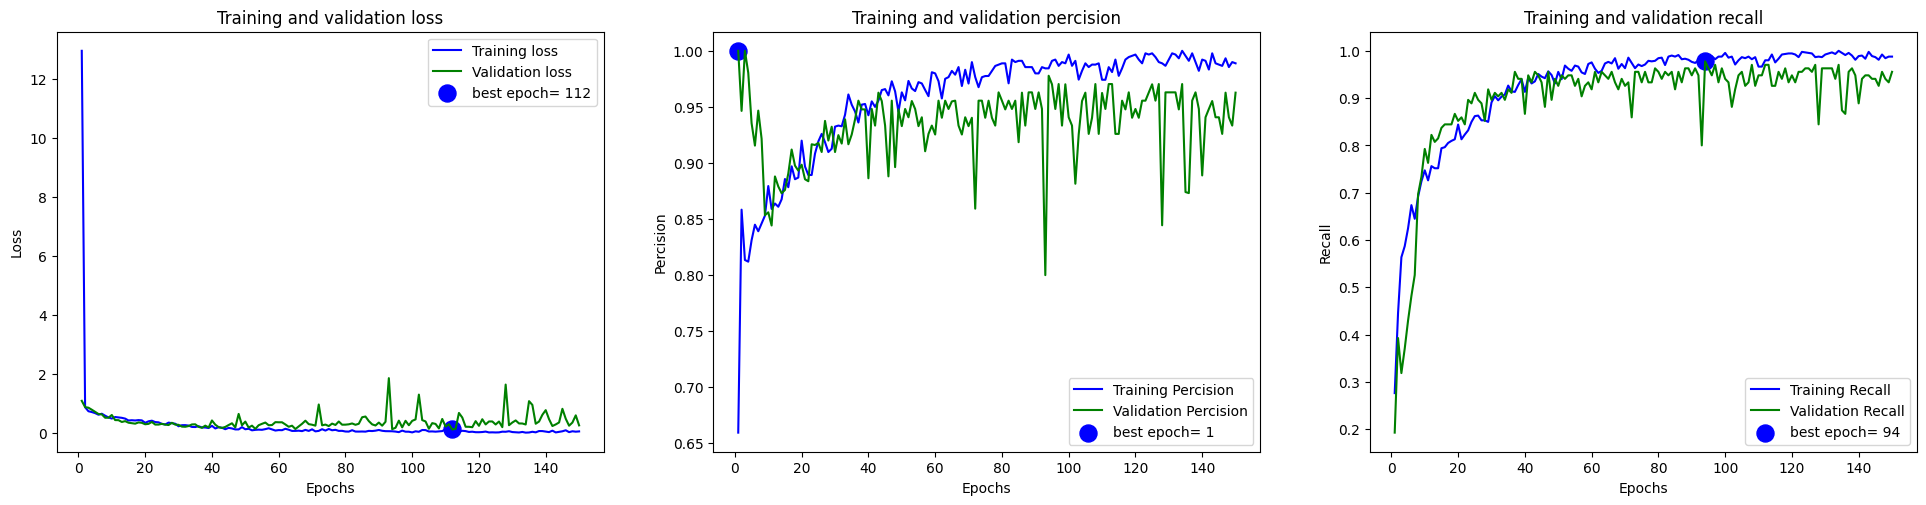

In [17]:
# Plot training history
plt.figure(figsize= (24, 12))

# Plot training and validation loss
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss, 'b', label= 'Training loss')
plt.plot(epochs, validation_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and validation loss')
plt.xlabel('Epochs' )
plt.ylabel('Loss')
plt.legend()

# Plot training and validation percision
plt.subplot(2, 3, 2)
plt.plot(epochs, train_perc, 'b', label= 'Training Percision')
plt.plot(epochs, validation_perc, 'g', label= 'Validation Percision')
plt.scatter(index_perc + 1 , perc_highest, s= 150, c= 'blue', label= perc_label)
plt.title('Training and validation percision')
plt.xlabel('Epochs')
plt.ylabel('Percision')
plt.legend()

# Plot training and validation recall
plt.subplot(2, 3, 3)
plt.plot(epochs, train_recall, 'b', label= 'Training Recall')
plt.plot(epochs, validation_recall, 'g', label= 'Validation Recall')
plt.scatter(index_recall + 1 , recall_highest, s= 150, c= 'blue', label= recall_label)
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

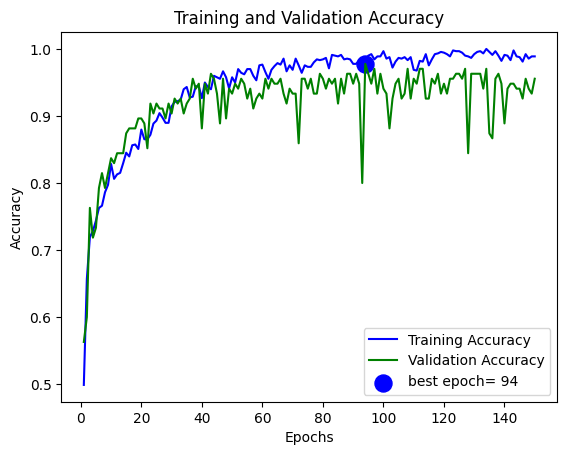

In [15]:
# Plot training an validation accuracy
plt.plot(epochs, train_acc, 'b', label= 'Training Accuracy')
plt.plot(epochs, validation_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Test our model

In [18]:
test_score = model.evaluate(test_gen, verbose= 1)

6/6 [==============================] - 1s 214ms/step - loss: 1.2751 - accuracy: 0.9000 - precision: 0.9000 - recall: 0.9000 - auc: 0.9431


#  Load model and run test

In [23]:
# Get data
image = getProcessedImage('./weather_dataset/Rain/rain10.jpg')
loaded_model = getModel(name)

# Make predictions
predictions = loaded_model.predict(image)

# Print out category
score = tf.nn.softmax(predictions[0])
print(f"{categories[tf.argmax(score)]}")

1/1 [==============================] - 0s 484ms/step
Rain
